In [22]:
pip install tensorflow pandas matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path dataset
train_dir = "./train"
valid_dir = "./valid"
test_dir = "./test"

IMG_SIZE = (224, 224)

# Baca file anotasi
train_annotations = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
test_annotations = pd.read_csv(os.path.join(test_dir, "_annotations.csv"))

In [24]:
print(train_annotations.columns)

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


In [25]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Pastikan data dalam rentang [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(train_dir, "_annotations.csv")),
    directory=train_dir,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical"
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_data = valid_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(valid_dir, "_annotations.csv")),
    directory=valid_dir,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Urutan tetap untuk validasi
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(test_dir, "_annotations.csv")),
    directory=test_dir,
    x_col="filename",
    y_col="class",  # Jika ada label; gunakan `None` jika tidak ada
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical",  # Gunakan `None` jika tanpa label
    shuffle=False  # Urutan tetap untuk evaluasi/prediksi
)

Found 9646 validated image filenames belonging to 17 classes.
Found 867 validated image filenames belonging to 17 classes.
Found 471 validated image filenames belonging to 17 classes.


In [26]:
print(f"Jumlah data training: {train_data.samples}")
print(f"Jumlah data validasi: {valid_data.samples}")
print(f"Jumlah data test: {test_data.samples}")

Jumlah data training: 9646
Jumlah data validasi: 867
Jumlah data test: 471


In [27]:
print(f"Kelas pada training data: {train_data.class_indices}")
print(f"Kelas pada validasi data: {valid_data.class_indices}")


Kelas pada training data: {'apel': 0, 'ayam_bakar': 1, 'ayam_goreng': 2, 'brokoli': 3, 'nasi_kuning': 4, 'nasi_putih': 5, 'pisang': 6, 'semangka': 7, 'tahu_kuning': 8, 'tahu_putih': 9, 'telur_balado': 10, 'telur_ceplok': 11, 'telur_dadar': 12, 'telur_rebus': 13, 'tempe': 14, 'timun': 15, 'tomat': 16}
Kelas pada validasi data: {'apel': 0, 'ayam_bakar': 1, 'ayam_goreng': 2, 'brokoli': 3, 'nasi_kuning': 4, 'nasi_putih': 5, 'pisang': 6, 'semangka': 7, 'tahu_kuning': 8, 'tahu_putih': 9, 'telur_balado': 10, 'telur_ceplok': 11, 'telur_dadar': 12, 'telur_rebus': 13, 'tempe': 14, 'timun': 15, 'tomat': 16}


In [28]:
# Ambil batch pertama dari training data
x_batch, y_batch = next(train_data)
print(f"Bentuk batch gambar: {x_batch.shape}")
print(f"Bentuk batch label: {y_batch.shape}")


Bentuk batch gambar: (32, 224, 224, 3)
Bentuk batch label: (32, 17)


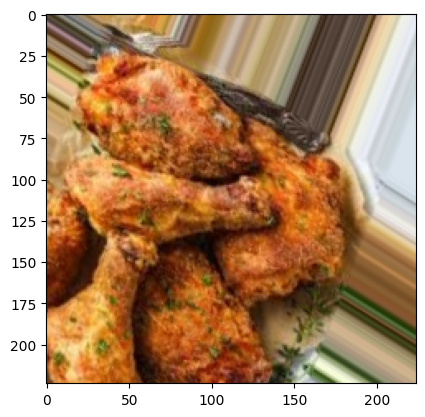

In [29]:
import matplotlib.pyplot as plt
for x_batch, y_batch in train_data:
    plt.imshow(x_batch[0])  # Gambar pertama dalam batch
    plt.show()
    break


In [30]:
# import pandas as pd

# annotations = pd.read_csv(os.path.join(train_dir, "_annotations.csv"))
# print(annotations['class'].value_counts())

# print("Jumlah kelas (output layer):", model.output_shape[-1])
# print("Jumlah kelas (data):", len(train_data.class_indices))


In [31]:
print("Jumlah total batch di training data:", len(train_data))
print("Jumlah gambar per batch:", train_data.batch_size)
print("Total gambar training:", len(train_data.filenames))

Jumlah total batch di training data: 302
Jumlah gambar per batch: 32
Total gambar training: 9646


In [32]:
model = tf.keras.Sequential([
    # Blok Konvolusi dan Pooling 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Blok Konvolusi dan Pooling 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Blok Konvolusi dan Pooling 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatenning
    tf.keras.layers.Flatten(),

    # Fully Connected Layer 1
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Fully Connected Layer 2
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Fully Connected Layer 3
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Lapisan Output
    tf.keras.layers.Dense(17, activation='softmax')  # 17 kelas
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model.summary()

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    11,075,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,492,177 (43.84 MB)

 Trainable params: 11,492,177 (43.84 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=valid_data.samples // valid_data.batch_size
)

# Evaluasi model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.2180 - loss: 2.7761 - val_accuracy: 0.2407 - val_loss: 2.4133
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 198us/step - accuracy: 0.2188 - loss: 2.3239 - val_accuracy: 0.3333 - val_loss: 2.9843
Epoch 3/50


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


301/301 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.2558 - loss: 2.3922 - val_accuracy: 0.2812 - val_loss: 2.3731
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 146us/step - accuracy: 0.2812 - loss: 2.5220 - val_accuracy: 0.3333 - val_loss: 3.1177
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.2824 - loss: 2.3256 - val_accuracy: 0.2951 - val_loss: 2.3887
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 155us/step - accuracy: 0.3438 - loss: 2.2053 - val_accuracy: 0.0000e+00 - val_loss: 3.1420
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.2890 - loss: 2.3045 - val_accuracy: 0.2963 - val_loss: 2.3422
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 141us/step - accuracy: 0.2812 - loss: 2.5127 - val_accuracy: 0.0000e+00 - val_loss: 2.9256
Epoch 9/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.3046 - loss: 2.2365 - val_accuracy: 0.3160 - val_loss: 2.2323
Epoch 10/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 354us/step - accuracy: 0.2500 - loss: 2.5434 - val_ac

In [34]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 662ms/step - accuracy: 0.4212 - loss: 1.6242
Test Loss: 1.6753458976745605, Test Accuracy: 0.42250531911849976


In [35]:
import numpy as np

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=-1)

# Melihat prediksi
print(predicted_classes)

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step
[ 7  7 15  2 12  9  6  6  6 15  9  9  6  6  6  2  2  2 12 12  2  2  2 15
 15 15  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  2  2  2  6  9  9 14
 15 15 15 15  2  2  2  2  2  6  6  6  2  2  2  2  2  2  2  2 15 13 13 13
  9  9  9  9  9  9  2  9 10 10 10 14  2  2  2  2  2  2 13 13 15  2  2  2
  2 10  2  2  2  2  2  2  2 13 13 13 13 13 13 13  2  2  2  2  2  2  2 14
 14  9  6  2  2  2  2  7  7  7  7  7 15 15  6  2  2  2  2  2  2  2 13 13
 13 15  2 12 12 12 12 12 13 13 13 15 15 13 13 13 13  2  9  9  9 13 13 13
 13 13 13  2 13 13  2  7  7  7  7  7  7  7  7  7  7  7  2 13 13 13 13  9
  2  2  2  2  2  7  7  7  7  2  2  2  2  2  2  2  6  7  6  6  2 15 13 13
 13  2  2  2  2  2  2  9  9  9  9 12  9 14 14  2  6  6  6  9  9 15 15 15
 15 15 15 15 15  9  9 14  9  7  7  7  7 12  6  6  7 14 14 13 13  9 13 13
 13 13 13  6  6  2  2  2  2  2  2  2  2  2 15 15 15 15 15 14 14  2  2  2
 12 12 12 12  7  2  2  2  2  2 14 14 14 14  6  6  6  2  6  6  6  6  6  6
 15 15 15

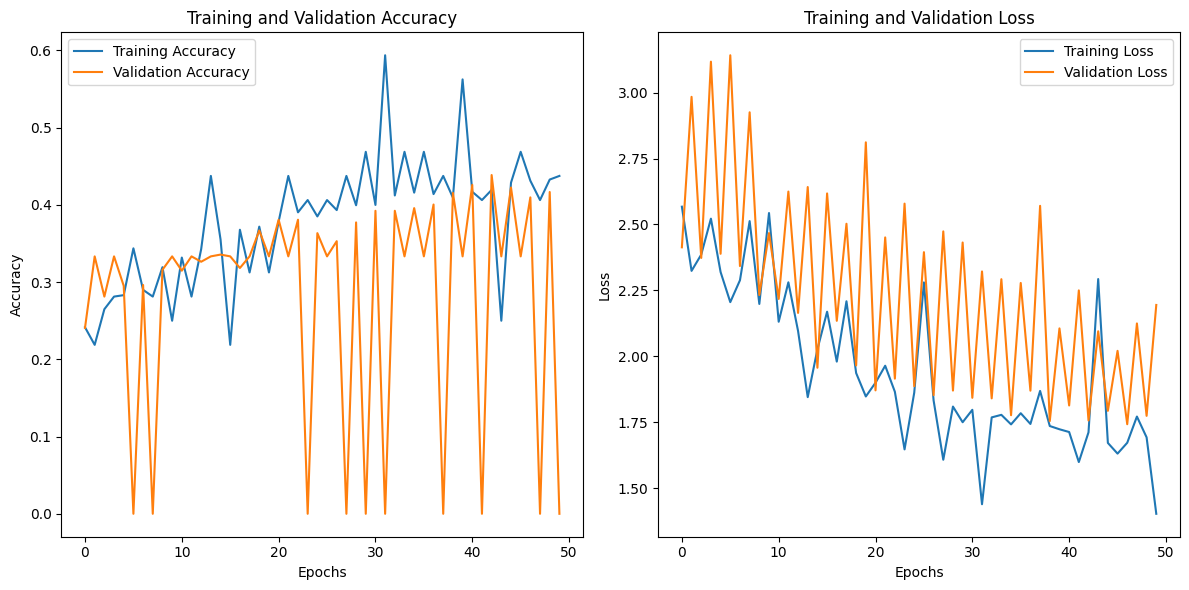

In [36]:
import matplotlib.pyplot as plt

# Plotting kurva akurasi
plt.figure(figsize=(12, 6))

# Plotting akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()